
# Climates like Flagstaff

## Background and motivation
The purpose of this analysis is to find climates like Flagstaff in other parts of the globe, preferably where the architecture isn't the result of recent colonization, and maybe also where the indigenous group is genetically similar to myself.

In [1]:

%pprint

Pretty printing has been turned OFF


In [2]:

%run ../load_magic/storage.py

s = Storage()


----
## Data sources and scale of data

NOAA has 2.5 million rows of weather station data in their Global Summary of the Year data

In [3]:

# Download the GNU zip file
from os.path import exists
import requests

gz_folder = '../saves/gz'
url = 'https://www.ncei.noaa.gov/data/global-summary-of-the-year/archive/gsoy-latest.tar.gz'
source_filename = url.split('/')[-1]
source_filepath = os.path.join(gz_folder, source_filename)
if not exists(source_filepath):
    os.makedirs(name=gz_folder, exist_ok=True)
    response = requests.get(url)
    with open(source_filepath, 'wb') as ibw:
        ibw.write(response.content)

In [4]:

# Write the tarball
import gzip

dest_filename = '.'.join(source_filename.split('.')[:-1])
tar_folder = '../saves/tar'
dest_filepath = os.path.join(tar_folder, dest_filename)
if not exists(dest_filepath):
    os.makedirs(name=tar_folder, exist_ok=True)
    with gzip.open(source_filepath, 'rb') as s_file, open(dest_filepath, 'wb') as d_file:
        while True:
            block = s_file.read(65_536)
            if not block:
                break
            else:
                d_file.write(block)

In [5]:

# Extract the CSVs
import tarfile

dest_folder = os.path.join(s.data_csv_folder, 'gsoy-latest')
if not exists(os.path.join(dest_folder, 'ACW00011647.csv')):
    os.makedirs(name=dest_folder, exist_ok=True)
    tar = tarfile.open(dest_filepath)
    tar.extractall(path=dest_folder)
    tar.close()

In [6]:

# Aggregate the CSVs and store them as a pickle and as a CSV
from tqdm.notebook import tqdm
tqdm.pandas()

if s.pickle_exists('climates_df'):
    climates_df = s.load_object('climates_df')
else:
    climates_df = pd.DataFrame([], columns=['csv_name'])
    csv_folder = os.path.join(s.data_csv_folder, 'gsoy-latest')
    csvs_list = [fn for fn in os.listdir(csv_folder) if fn.endswith('.csv')]
    for csv_name in tqdm(csvs_list):
        csv_path = os.path.join(csv_folder, csv_name)
        df = pd.read_csv(os.path.abspath(csv_path), encoding=s.encoding_type)
        df['csv_name'] = csv_name
        climates_df = pd.concat([climates_df, df], axis='index', ignore_index=True)
    s.store_objects(climates_df=climates_df, verbose=True)
    s.save_dataframes(climates_df=climates_df)


----
## Feature generation and data wrangling

### Add an Elevation-difference-from-Flagstaff column

In [7]:

from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
import matplotlib.pyplot as plt

# Use sample map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

In [8]:

# Flagstaff is 2108 meters with elevation that is 1829 meters higher than average city elevation in United States.
# Scale of surrounding elevation is from 2068 to 2472 m with average elevation of 2150.3 meters.
if 'elevation_diff' not in climates_df.columns:
    climates_df['elevation_diff'] = climates_df.ELEVATION.map(lambda x: abs(x - 2108))
    s.store_objects(climates_df=climates_df, verbose=True)
    s.save_dataframes(climates_df=climates_df, verbose=True)

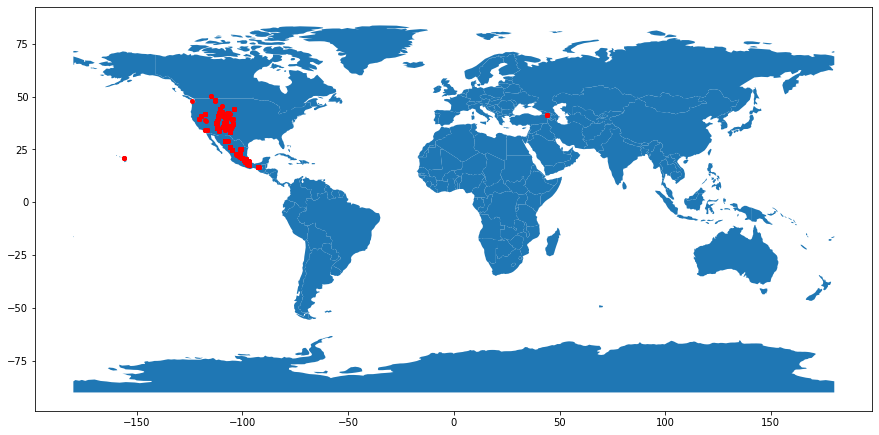

In [9]:

mask_series = (climates_df.elevation_diff < 10)
df = climates_df[mask_series].sample(min(1_000, climates_df[mask_series].shape[0]))
geometry = [Point(xy) for xy in zip(df.LONGITUDE, df.LATITUDE)]
gdf = GeoDataFrame(df, geometry=geometry)
gdf.plot(ax=world.plot(figsize=(15, 15)), marker='o', color='red', markersize=15);


### Add Geodesic-distance-to-Flagstaff column

In [10]:

# Add column for distance to Flagstaff, AZ, USA
# Latitude and longitude coordinates are: 35.198284, -111.651299
import math
import numpy as np
from geopy.distance import distance

if 'distance_to_flagstaff' not in climates_df.columns:
    flagstaff_az = (-35.198284, 111.651299)
    def f(row_series):
        distance_to_flagstaff = np.nan
        latitude = row_series.LATITUDE
        longitude = row_series.LONGITUDE
        if (str(latitude) != 'nan') and (str(longitude) != 'nan'):
            lat_lon_tuple = (latitude, longitude)
            distance_to_flagstaff = distance(flagstaff_az, lat_lon_tuple).km

        return distance_to_flagstaff
    climates_df['distance_to_flagstaff'] = climates_df.progress_apply(f, axis='columns')
    s.store_objects(climates_df=climates_df, verbose=True)
    s.save_dataframes(climates_df=climates_df, verbose=True)

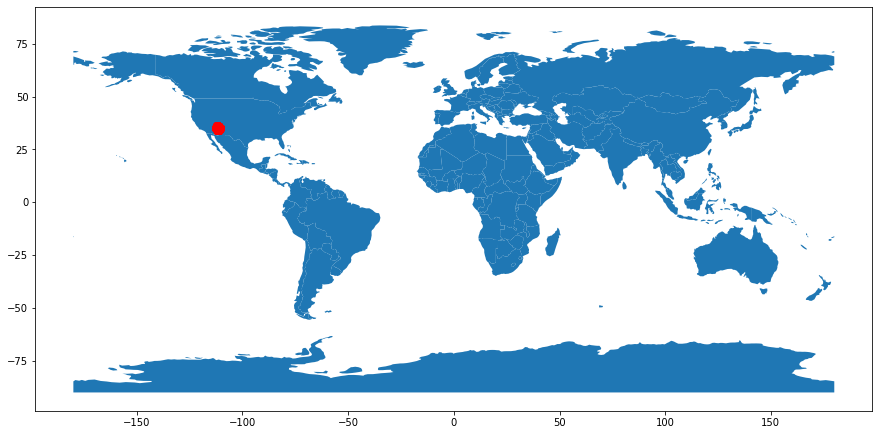

In [11]:

mask_series = (climates_df.distance_to_flagstaff < 2)
df = climates_df[mask_series].sample(min(1_000, climates_df[mask_series].shape[0]))
geometry = [Point(xy) for xy in zip(df.LONGITUDE, df.LATITUDE)]
gdf = GeoDataFrame(df, geometry=geometry)
gdf.plot(ax=world.plot(figsize=(15, 15)), marker='o', color='red', markersize=15);


----
## Model development and model selection
### Use Random Forest to get the Features that are important to being nearby Flagstaff

In [12]:

# Figure out which observations we know for sure are the same climate as Flagstaff
def f(x):
    
    return 'flagstaff' in str(x).lower()
mask_series = climates_df.NAME.map(f)
columns_list = ['distance_to_flagstaff', 'STATION', 'NAME', 'LATITUDE', 'LONGITUDE', 'ELEVATION']
climates_df[mask_series][columns_list].sort_values('distance_to_flagstaff').head(200).tail(20)

,distance_to_flagstaff,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION
1635387,0.113344,US1AZCN0002,"FLAGSTAFF 7.8 SSW, AZ US",35.093850,-111.695350,2078.7
1635385,0.113344,US1AZCN0002,"FLAGSTAFF 7.8 SSW, AZ US",35.093850,-111.695350,2078.7
1635384,0.113344,US1AZCN0002,"FLAGSTAFF 7.8 SSW, AZ US",35.093850,-111.695350,2078.7
1635383,0.113344,US1AZCN0002,"FLAGSTAFF 7.8 SSW, AZ US",35.093850,-111.695350,2078.7
1635389,0.113344,US1AZCN0002,"FLAGSTAFF 7.8 SSW, AZ US",35.093850,-111.695350,2078.7
1635426,0.130167,US1AZCN0092,"FLAGSTAFF 8.2 NE, AZ US",35.268021,-111.541389,2041.9
1635425,0.130167,US1AZCN0092,"FLAGSTAFF 8.2 NE, AZ US",35.268021,-111.541389,2041.9
1635433,0.147351,US1AZCN0140,"FLAGSTAFF 9.8 NNE, AZ US",35.309071,-111.554146,2088.5
1635434,0.147351,US1AZCN0140,"FLAGSTAFF 9.8 NNE, AZ US",35.309071,-111.554146,2088.5
1635435,0.185256,US1AZCN0154,"FLAGSTAFF 10.5 E, AZ US",35.217705,-111.467064,1967.5


In [13]:

# Check observations close to Flagstaff without being explicitly named
def f(x):
    
    return 'flagstaff' in str(x).lower()
mask_series = (climates_df.distance_to_flagstaff < 0.2) & ~climates_df.NAME.map(f)
columns_list = ['distance_to_flagstaff', 'STATION', 'NAME', 'LATITUDE', 'LONGITUDE', 'ELEVATION']
climates_df[mask_series][columns_list].sort_values('distance_to_flagstaff')

,distance_to_flagstaff,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION
2418721,0.114066,USS0011P02S,"FORT VALLEY, AZ US",35.2700,-111.7400,2240.3
2418733,0.114066,USS0011P02S,"FORT VALLEY, AZ US",35.2700,-111.7400,2240.3
2418732,0.114066,USS0011P02S,"FORT VALLEY, AZ US",35.2700,-111.7400,2240.3
2418731,0.114066,USS0011P02S,"FORT VALLEY, AZ US",35.2700,-111.7400,2240.3
2418730,0.114066,USS0011P02S,"FORT VALLEY, AZ US",35.2700,-111.7400,2240.3
...,...,...,...,...,...,...
1695078,0.173757,USC00020678,"BELLEMONT WEATHER FORECAST OFFICE, AZ US",35.2302,-111.8221,2179.9
1695079,0.173757,USC00020678,"BELLEMONT WEATHER FORECAST OFFICE, AZ US",35.2302,-111.8221,2179.9
1695080,0.173757,USC00020678,"BELLEMONT WEATHER FORECAST OFFICE, AZ US",35.2302,-111.8221,2179.9
1695070,0.173757,USC00020678,"BELLEMONT WEATHER FORECAST OFFICE, AZ US",35.2302,-111.8221,2179.9


In [14]:

# Get list of stations nearby Flagstaff
if s.pickle_exists('flagstaff_nearby_list'):
    nearby_list = s.load_object('flagstaff_nearby_list')
else:
    climates_df = climates_df.reset_index(drop=True)
    nearby_list = climates_df[climates_df.distance_to_flagstaff < 0.2].index.tolist()
    s.store_objects(flagstaff_nearby_list=nearby_list)

In [15]:

# Get numeric columns
%run ../load_magic/dataframes.py

if s.pickle_exists('climates_numeric_columns_list'):
    numeric_columns_list = s.load_object('climates_numeric_columns_list')
else:
    get_column_descriptions_df = get_column_descriptions(climates_df.sample(min(5_000, climates_df.shape[0])))
    mask_series = ~get_column_descriptions_df.column_name.isin(['distance_to_flagstaff', 'LONGITUDE', 'LATITUDE', 'elevation_diff', 'DATE', 'index'])
    mask_series = mask_series & get_column_descriptions_df.dtype.isin(['int64', 'float64']) & (get_column_descriptions_df.count_uniques > 2)
    df = get_column_descriptions_df[mask_series].sort_values(['count_uniques'], ascending=[False])
    numeric_columns_list = df.column_name.tolist()
    s.store_objects(climates_numeric_columns_list=numeric_columns_list)
    display(df)

In [16]:

# Show columns important for determining if like Flagstaff
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

if s.pickle_exists('flagstaff_feature_importances_tuples_list'):
    feature_importances_tuples_list = s.load_object('flagstaff_feature_importances_tuples_list')
else:
    
    # Warning: impurity-based feature importances can be misleading for high cardinality features (many unique values)
    # feature_importances_tuples_list = sorted([(cn, ci) for cn, ci in zip(numeric_columns_list, rfclf.feature_importances_) if ci > 0.0],
    #                                          key=lambda x: x[1], reverse=True)[:6]
    # print(feature_importances_tuples_list)
    
    X = climates_df[numeric_columns_list].fillna(0).values
    y = climates_df.index.isin(nearby_list)
    
    # Create the Random Forest Classifier
    if s.pickle_exists('climates_rfclf'):
        rfclf = s.load_object('climates_rfclf')
    else:
        rfclf = RandomForestClassifier()
        rfclf.fit(X, y)
        s.store_objects(climates_rfclf=rfclf)
    
    result = permutation_importance(rfclf, X, y, n_repeats=10)
    feature_importances_tuples_list = sorted([(cn, ci) for cn, ci in zip(numeric_columns_list, result.importances_mean)], key=lambda x: x[1], reverse=True)[:6]
    s.store_objects(flagstaff_feature_importances_tuples_list=feature_importances_tuples_list)
print(feature_importances_tuples_list)

[('ELEVATION', 0.000182097379708257), ('DT32', 8.42623284901367e-05), ('TMAX', 5.8788596683967406e-05), ('PRCP', 3.482736770377137e-05), ('HTDD', 3.0409267343634026e-05), ('EMXP', 2.9772424048468694e-05)]


In [17]:

import geoplot

geoplot.kdeplot?

ImportError: DLL load failed while importing _base: The specified procedure could not be found.

In [ ]:

ax = geoplot.kdeplot(
    collisions.head(1000), clip=boroughs.geometry,
    shade=True, cmap='Reds',
    projection=geoplot.crs.AlbersEqualArea())
geoplot.polyplot(boroughs, ax=ax, zorder=1)


# Use the Nearby Minimum and Maximum of the Important Features to create the is-like-Flagstaff Column

In [14]:

columns_list = [fi_tuple[0] for fi_tuple in feature_importances_tuples_list]
if 'is_like_flagstaff' not in climates_df.columns:
    mask_series = climates_df.index.isin(nearby_list)
    df = climates_df[mask_series][columns_list].describe()
    mask_series = True
    for column_name in columns_list:
        mask_series = mask_series & (climates_df[column_name] >= df.loc['min', column_name]) & (climates_df[column_name] <= df.loc['max', column_name])
    climates_df['is_like_flagstaff'] = False
    climates_df.loc[mask_series, 'is_like_flagstaff'] = True
    s.store_objects(climates_df=climates_df, verbose=True)
    s.save_dataframes(climates_df=climates_df, verbose=True)
columns_list = ['distance_to_flagstaff', 'STATION', 'NAME', 'LATITUDE', 'LONGITUDE'] + columns_list
climates_df[climates_df.is_like_flagstaff][columns_list].sample(20).sort_values('distance_to_flagstaff')

,distance_to_flagstaff,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,DT32,TMAX,PRCP,HTDD,EMXP
1703826,1.664498,USC00026581,"PINEDALE, AZ US",34.30000,-110.25000,1983.0,196.0,18.09,527.3,3568.4,42.4
2413332,2.536888,USS0009S02S,"MAVERICK FORK, AZ US",33.92000,-109.46000,2804.2,196.0,12.46,799.4,4295.5,53.3
2411867,2.874158,USS0008N03S,"NAVAJO WHISKEY CK, NM US",36.18000,-108.95000,2758.4,160.0,12.24,695.3,4234.6,33.0
2058126,3.129499,USC00293305,"FORT WINGATE, NM US",35.46667,-108.53333,2135.1,157.0,18.54,313.8,NaN,30.5
2062560,3.394010,USC00295800,"MOGOLLON, NM US",33.38333,-108.78333,2073.9,153.0,17.88,810.4,2927.3,55.1
1766719,3.755481,USC00052342,"DOVE CREEK, CO US",37.76720,-108.91190,2091.8,148.0,16.24,396.7,3536.8,41.9
2061756,4.548444,USC00295353,"MAGDALENA, NM US",34.11667,-107.23333,1993.4,142.0,18.98,262.6,2908.7,18.5
2065478,4.803387,USC00297346,"REGINA, NM US",36.18333,-106.95000,2272.0,203.0,17.94,254.8,3659.7,13.0
2066349,5.285753,USC00298015,"SANDIA PARK, NM US",35.21056,-106.36556,2142.7,147.0,16.08,453.8,3264.4,30.5
2054635,5.356748,USC00291664,"CHAMA, NM US",36.91770,-106.57800,2392.7,240.0,14.36,486.3,4675.8,29.5



# Display the farthest away Flagstaff-like Weather Stations

In [15]:

columns_list = ['distance_to_flagstaff', 'STATION', 'NAME', 'LATITUDE', 'LONGITUDE', 'wikipedia_url'] + [fi_tuple[0] for fi_tuple in feature_importances_tuples_list]
mask_series = climates_df.is_like_flagstaff
df = climates_df[mask_series][columns_list].sort_values('NAME')
mask_series = (df.NAME.shift(-1) != df.NAME)
df[mask_series].sort_values('distance_to_flagstaff', ascending=False).head(20)

,distance_to_flagstaff,STATION,NAME,LATITUDE,LONGITUDE,wikipedia_url,ELEVATION,DT32,TMAX,PRCP,HTDD,EMXP
909546,215.233385,CHM00056182,"SONGPAN, CH",32.65000,103.56700,https://en.wikipedia.org/wiki/Songpan_County,2852.0,160.0,15.53,586.9,3608.5,29.5
909110,214.551391,CHM00056080,"HEZUO, CH",35.00000,102.90000,https://en.wikipedia.org/wiki/Hezuo,2910.0,226.0,10.61,590.9,5461.0,39.8
909482,213.909729,CHM00056172,"BARKAM, CH",31.90000,102.23300,https://en.wikipedia.org/wiki/Barkam,2666.0,139.0,19.42,588.8,2754.5,21.9
904622,213.423014,CHM00052866,"XINING, CH",36.61700,101.76700,https://en.wikipedia.org/wiki/Xining,2296.0,179.0,12.70,352.9,NaN,32.6
1183854,187.754848,KG000036974,"NARYN, KG",41.43310,76.00000,https://en.wikipedia.org/wiki/Naryn,2041.0,167.0,11.17,246.1,5158.0,9.7
1611693,183.165762,TI000038954,"KHOROG, TI",37.50000,71.50000,https://en.wikipedia.org/wiki/Khorugh,2077.0,141.0,14.44,441.9,3673.4,27.3
1544781,114.033080,SPE00156387,"NURIA, SP",42.38170,2.15530,https://en.wikipedia.org/wiki/Vall_de_N%C3%BAria,1971.0,162.0,10.19,762.6,4519.2,46.8
1544714,113.661978,SPE00156333,"MALNIU, SP",42.46580,1.77810,NaN,2230.0,151.0,9.66,1000.9,4492.6,48.6
2099526,29.372843,USC00315922,"MOUNT MITCHELL 2 SSW, NC US",35.73333,-82.28333,NaN,1991.9,153.0,9.63,1249.1,4878.2,68.6
1287517,21.655098,MXN00021031,"CUESTA BLANCA, MX",18.85000,-97.45000,NaN,2383.8,158.0,15.05,479.1,3918.7,50.5



<img src="https://upload.wikimedia.org/wikipedia/commons/3/3f/Sierra_Madre.jpg" width="100%" />


----
# Check if there exists some Clustering Algorithm that naturally bunches those weather stations near Flagstaff

In [36]:

from functools import partial
from sklearn import manifold
from collections import OrderedDict
from sklearn.decomposition import PCA, IncrementalPCA, KernelPCA
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import FactorAnalysis
from sklearn.decomposition import FastICA

# Set-up manifold methods
n_neighbors = 10
n_components = 2
LLE = partial(
    manifold.LocallyLinearEmbedding,
    n_neighbors=n_neighbors,
    n_components=n_components,
    eigen_solver='auto',
)

methods = OrderedDict()
methods['LLE'] = LLE(method='standard')
methods['LTSA'] = LLE(method='ltsa', eigen_solver='dense')
methods['Hessian LLE'] = LLE(method='hessian')
methods['Modified LLE'] = LLE(method='modified')
methods['Isomap'] = manifold.Isomap(n_neighbors=n_neighbors, n_components=n_components)
methods['MDS'] = manifold.MDS(n_components, max_iter=100, n_init=1)
methods['SE'] = manifold.SpectralEmbedding(
    n_components=n_components, n_neighbors=n_neighbors
)
methods['t-SNE'] = manifold.TSNE(n_components=n_components, init='pca', random_state=0)
methods['Incremental PCA'] = IncrementalPCA(n_components=n_components, batch_size=10)
methods['PCA'] = PCA(n_components=n_components)
methods['Kernel PCA'] = KernelPCA(kernel='rbf', fit_inverse_transform=True, gamma=10)
methods['Truncated SVD'] = TruncatedSVD(n_components=n_components)
methods['Factor Analysis'] = FactorAnalysis(n_components=n_components)
methods['Fast ICA'] = FastICA(n_components=n_components)

In [37]:

# Get the climates dataset. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
n_samples = 1500
columns_list = [fi_tuple[0] for fi_tuple in feature_importances_tuples_list]
mask_series = climates_df.index.isin(nearby_list)
sample_df = climates_df[mask_series][columns_list]
if sample_df.shape[0] < n_samples:
    sample_df = pd.concat([sample_df, climates_df[~mask_series][columns_list].sample(n_samples - sample_df.shape[0])])
else:
    sample_df = sample_df.sample(n_samples)

Error in determining null-space with ARPACK. Error message: 'Factor is exactly singular'. Note that eigen_solver='arpack' can fail when the weight matrix is singular or otherwise ill-behaved. In that case, eigen_solver='dense' is recommended. See online documentation for more information.


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


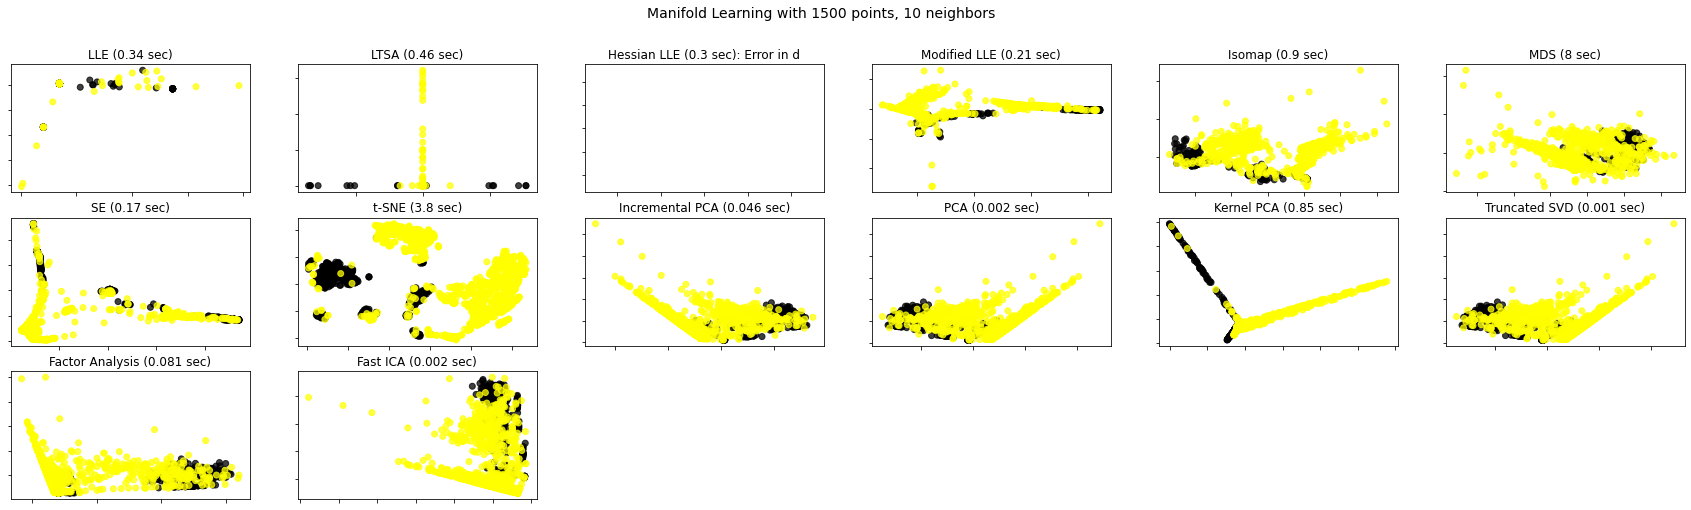

In [38]:

import matplotlib.pyplot as plt
from time import time
from matplotlib.ticker import NullFormatter
from sklearn.preprocessing import StandardScaler

colors_list = []
for idx in sample_df.index:
    if idx in nearby_list:
        colors_list.append('black')
    else:
        colors_list.append('yellow')
X1 = sample_df.fillna(0).values
scaler = StandardScaler().fit(X1)
X1_scaled = scaler.transform(X1)

# Create figure
fig = plt.figure(figsize=(30, 8))
fig.suptitle(
    'Manifold Learning with %i points, %i neighbors' % (n_samples, n_neighbors), fontsize=14
)

# Plot results
for i, (label, method) in enumerate(methods.items()):
    ax = fig.add_subplot(3, 6, 1 + i)
    t0 = time()
    try:
        y1 = method.fit_transform(X1_scaled)
        t1 = time()
        ax.set_title('%s (%.2g sec)' % (label, t1 - t0))
        ax.scatter(y1[:, 0], y1[:, 1], c=colors_list, cmap=plt.cm.Spectral, alpha=0.75)
    except (SystemError, RuntimeError, ValueError) as e:
        t1 = time()
        ax.set_title('%s (%.2g sec): %s' % (label, t1 - t0, str(e).strip()[:10]))
        print(str(e).strip())
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis('tight')


It looks like PCA naturally bunches those weather stations near Flagstaff. Now let's try some clustering algorithms, visualized with PCA.

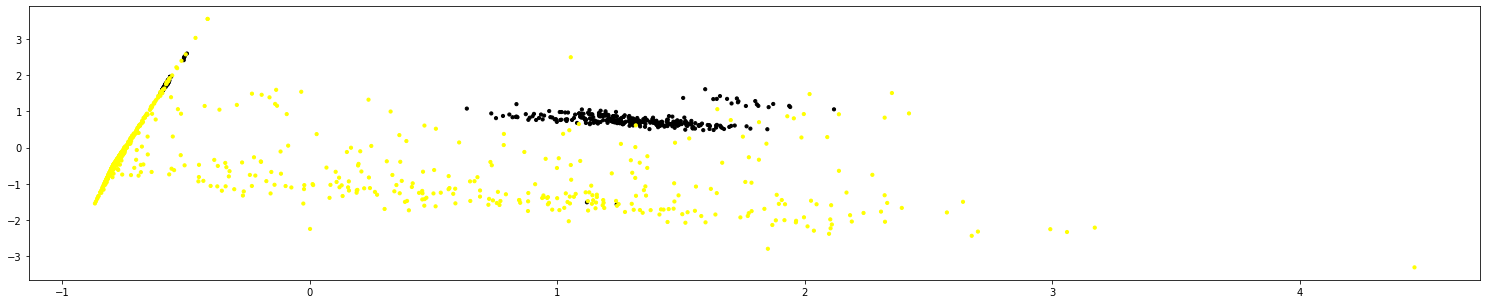

In [39]:

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

colors_list = []
df = sample_df.fillna(0)
for idx in df.index:
    if idx in nearby_list:
        colors_list.append('black')
    else:
        colors_list.append('yellow')

X = df.values
if X.shape[1] > 2:
    X = PCA(n_components=2).fit_transform(X)

# Normalize dataset for easier parameter selection
X = StandardScaler().fit_transform(X)

plt.figure(figsize=(21, 4))
plt.subplots_adjust(
    left=0.02, right=0.98, bottom=0.001, top=0.95, wspace=0.05, hspace=0.01
)
plt.scatter(X[:, 0], X[:, 1], s=10, color=colors_list);

In [72]:

from sklearn import cluster, mixture
from sklearn.neighbors import kneighbors_graph
import time
import warnings
import numpy as np
from itertools import cycle, islice

params = {
    'quantile': 0.3,
    'eps': 0.3,
    'damping': 0.76,
    'preference': -200,
    'n_neighbors': 10,
    'n_clusters': 4,
    'min_samples': 20,
    'xi': 0.05,
    'min_cluster_size': 0.1,
}

# Estimate bandwidth for mean shift
bandwidth = cluster.estimate_bandwidth(X, quantile=params['quantile'])

# Connectivity matrix for structured Ward
connectivity = kneighbors_graph(
    X, n_neighbors=params['n_neighbors'], include_self=False
)

# Make connectivity symmetric
connectivity = 0.5 * (connectivity + connectivity.T)

# ============
# Create cluster objects
# ============
ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
two_means = cluster.MiniBatchKMeans(n_clusters=params['n_clusters'])
ward = cluster.AgglomerativeClustering(
    n_clusters=params['n_clusters'], linkage='ward', connectivity=connectivity
)
spectral = cluster.SpectralClustering(
    n_clusters=params['n_clusters'],
    eigen_solver='arpack',
    affinity='nearest_neighbors',
)
dbscan = cluster.DBSCAN(eps=params['eps'])
optics = cluster.OPTICS(
    min_samples=params['min_samples'],
    xi=params['xi'],
    min_cluster_size=params['min_cluster_size'],
)
affinity_propagation = cluster.AffinityPropagation(
    damping=params['damping'], preference=params['preference'], random_state=0
)
average_linkage = cluster.AgglomerativeClustering(
    linkage='average',
    affinity='cityblock',
    n_clusters=params['n_clusters'],
    connectivity=connectivity,
)
birch = cluster.Birch(n_clusters=params['n_clusters'])
gmm = mixture.GaussianMixture(
    n_components=params['n_clusters'], covariance_type='full'
)

In [63]:

def get_colors_array(y_pred):
    colors_array = np.array(
        list(
            islice(
                cycle([
                    '#377eb8',
                    '#ff7f00',
                    '#4daf4a',
                    '#f781bf',
                    '#a65628',
                    '#984ea3',
                    '#999999',
                    '#e41a1c',
                    '#dede00',
                ]),
                int(max(y_pred) + 1),
            )
        )
    )
    
    # Add black color for outliers (if any)
    colors_array = np.append(colors_array, ['#000000'])
    
    return colors_array

In [64]:

def get_ypred(algorithm, X):
    t0 = time.time()

    # catch warnings related to kneighbors_graph
    with warnings.catch_warnings():
        warnings.filterwarnings(
            'ignore',
            message='the number of connected components of the '
            + 'connectivity matrix is [0-9]{1,2}'
            + ' > 1. Completing it to avoid stopping the tree early.',
            category=UserWarning,
        )
        warnings.filterwarnings(
            'ignore',
            message='Graph is not fully connected, spectral embedding'
            + ' may not work as expected.',
            category=UserWarning,
        )
        algorithm.fit(X)

    t1 = time.time()
    if hasattr(algorithm, 'labels_'):
        y_pred = algorithm.labels_.astype(int)
    else:
        y_pred = algorithm.predict(X)
    
    return t0, t1, y_pred

In [65]:

def show_scatter_row(algorithm_tuples_list, get_ypred):
    plt.figure(figsize=(21, 4))
    plt.subplots_adjust(
        left=0.02, right=0.98, bottom=0.001, top=0.95, wspace=0.05, hspace=0.01
    )
    plot_num = 1
    for name, algorithm in algorithm_tuples_list:
        t0, t1, y_pred = get_ypred(algorithm, X)

        plt.subplot(1, len(algorithm_tuples_list), plot_num)
        plt.title(name, size=18)

        colors_array = get_colors_array(y_pred)
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors_array[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(
            0.99,
            0.01,
            ('%.2fs' % (t1 - t0)).lstrip('0'),
            transform=plt.gca().transAxes,
            size=15,
            horizontalalignment='right',
        )
        plot_num += 1

    plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


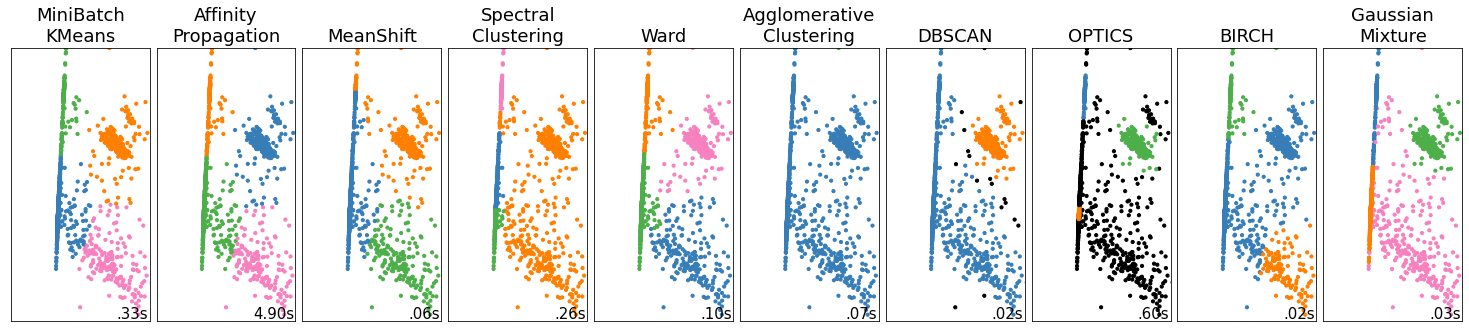

In [73]:

clustering_algorithms = (
    ('MiniBatch\nKMeans', two_means),
    ('Affinity\nPropagation', affinity_propagation),
    ('MeanShift', ms),
    ('Spectral\nClustering', spectral),
    ('Ward', ward),
    ('Agglomerative\nClustering', average_linkage),
    ('DBSCAN', dbscan),
    ('OPTICS', optics),
    ('BIRCH', birch),
    ('Gaussian\nMixture', gmm),
)
show_scatter_row(clustering_algorithms, get_ypred)


It looks like many of these clustering algorithms label the two blobs separately from the rest.

In [87]:

columns_list = [fi_tuple[0] for fi_tuple in feature_importances_tuples_list]
filled_df = climates_df[columns_list].fillna(0)

In [110]:

while climates_df.dbscan_label.isnull().any():
    sample_df = filled_df.sample(10_000)
    X = StandardScaler().fit_transform(sample_df.values)
    t0, t1, y_pred = get_ypred(dbscan, X)
    mask_series = climates_df.index.isin(sample_df.index)
    climates_df.loc[mask_series, 'dbscan_label'] = y_pred

In [119]:

climates_df.groupby(['dbscan_label']).is_near_flagstaff.value_counts(dropna=False).head(20)

dbscan_label  is_near_flagstaff
-1.0          False                 817134
              True                     136
 0.0          False                1341052
              True                     245
 1.0          False                 157386
              True                      25
 2.0          False                  28347
              True                       3
 3.0          False                  17435
              True                       9
 4.0          False                  12898
              True                       2
 5.0          False                  10701
              True                       4
 6.0          False                   7833
              True                       1
 7.0          False                   6888
              True                       1
 8.0          False                   5684
              True                       1
Name: is_near_flagstaff, dtype: int64

In [120]:

columns_list = ['STATION', 'NAME', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'distance_to_flagstaff', 'elevation_diff',
                'dbscan_label', 'is_like_flagstaff', 'is_near_flagstaff']
mask_series = (climates_df.dbscan_label == 0)
climates_df[mask_series][columns_list].sample(10).T

,1600926,640696,619414,2220668,1345522,1343376,1161118,520800,495408,2509885
STATION,SWE00140670,BR001444005,ASN00097000,USC00406709,NLE00109126,NLE00109060,IN023420800,ASN00079038,ASN00074221,WA009647830
NAME,"ARJEPLOG A, SW","LAGOA DAS PEDRAS, BR","CAPE SORELL, AS","OAK GROVE, TN US","HENDRIK IDO AMBACHT, NL","EERBEEK, NL","MUKTESHWAR KUMAON, IN","POMONAL WINDY RIDGE, AS","NARRANDERA GOLF CLUB, AS","OMAMBONDE, WA"
LATITUDE,66.0522,-14.28,-42.1986,35.66667,51.8331,52.1167,29.467,-37.2,-34.7325,-20.05
LONGITUDE,17.8431,-44.41,145.17,-88.35,4.65,6.0667,79.65,142.6,146.5592,17.95
ELEVATION,431.0,450.0,19.3,161.8,-1.0,15.0,2311.0,320.0,173.0,1310.0
distance_to_flagstaff,133.119358,83.483489,268.230232,23.306006,117.484932,118.927541,191.387133,264.358156,267.512572,140.886016
elevation_diff,1677.0,1658.0,2088.7,1946.2,2109.0,2093.0,203.0,1788.0,1935.0,798.0
dbscan_label,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
is_like_flagstaff,False,False,False,False,False,False,False,False,False,False
is_near_flagstaff,False,False,False,False,False,False,False,False,False,False


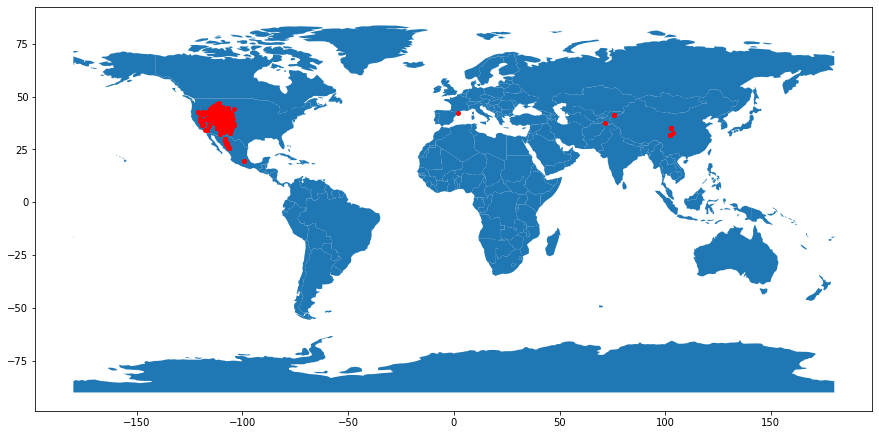

In [17]:

from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
import matplotlib.pyplot as plt

# mask_series = (climates_df.dbscan_label == 0)
# mask_series = climates_df.is_near_flagstaff
mask_series = climates_df.is_like_flagstaff
df = climates_df[mask_series].sample(min(1_000, climates_df[mask_series].shape[0]))
geometry = [Point(xy) for xy in zip(df.LONGITUDE, df.LATITUDE)]
gdf = GeoDataFrame(df, geometry=geometry)

# Use sample map
# world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(15, 15)), marker='o', color='red', markersize=15);

In [85]:

colors_list = []
for idx in df.index:
    if idx in nearby_list:
        colors_list.append('black')
    else:
        colors_list.append('yellow')
rows_list = []
for color, label in zip(colors_list, y_pred):
    row_dict = {}
    row_dict['color'] = color
    row_dict['label'] = label
    rows_list.append(row_dict)
df = pd.DataFrame(rows_list)

In [86]:

df.sort_values('label', ascending=False)

,color,label
8538,yellow,61
201,yellow,61
501,yellow,61
9300,yellow,61
6491,yellow,61
...,...,...
5709,yellow,-1
1494,yellow,-1
2863,yellow,-1
1492,yellow,-1


In [77]:

color_label_groupby = df.groupby(['color', 'label'])
color_label_groupby.value_counts()

color   label
yellow  -1       3183
         0       5788
         1         32
         2         68
         3         14
                 ... 
         55         5
         56         1
         57         6
         58         4
         59         5
Length: 61, dtype: int64


# Add a Wikipedia URL Column

In [15]:

import wikipedia
import numpy as np
from wikipedia.exceptions import (PageError, DisambiguationError, WikipediaException)
from IPython.display import clear_output
from time import sleep

if ('wikipedia_url' not in climates_df.columns) or climates_df.wikipedia_url.isnull().all():
    mask_series = climates_df.is_like_flagstaff & climates_df.wikipedia_url.isnull()
    for row_index, row_series in climates_df[mask_series].iterrows():
        latitude = row_series.LATITUDE
        longitude = row_series.LONGITUDE
        titles_list = wikipedia.geosearch(latitude=latitude, longitude=longitude, radius=10_000)
        if titles_list:
            try:
                wikipedia_url = wikipedia.page(title=titles_list[0]).url
                climates_df.loc[row_index, 'wikipedia_url'] = wikipedia_url
                clear_output(wait=True)
                print(f'{row_series.NAME}: {wikipedia_url}')
            except (PageError, DisambiguationError) as e:
                clear_output(wait=True)
                print(f'{row_series.NAME}: {str(e).strip()}')
            except (WikipediaException) as e:
                clear_output(wait=True)
                print(f'{row_series.NAME}: {str(e).strip()}')
                sleep(60)
    s.store_objects(climates_df=climates_df, verbose=True)
    s.save_dataframes(climates_df=climates_df)


# Make a Bounding Box around Europe

In [17]:

westernmost_longitude = -9.500556
easternmost_longitude = 66.618056
northernmost_latitude = 71.133889
southernmost_latitude = 36
mask_series = climates_df.is_like_flagstaff
mask_series = mask_series & (climates_df.LATITUDE <= northernmost_latitude) & (climates_df.LATITUDE >= southernmost_latitude)
mask_series = mask_series & (climates_df.LONGITUDE >= westernmost_longitude) & (climates_df.LONGITUDE <= easternmost_longitude)
columns_list = ['STATION', 'NAME', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'distance_to_flagstaff', 'elevation_diff', 'wikipedia_url']
df = climates_df[mask_series][columns_list]
df = df.sort_values('distance_to_flagstaff', ascending=False)
df.loc[df.NAME.shift(-1) != df.NAME].head(20)

,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,distance_to_flagstaff,elevation_diff,wikipedia_url
1544786,SPE00156387,"NURIA, SP",42.3817,2.1553,1971.0,114.033080,137.0,https://en.wikipedia.org/wiki/Vall_de_N%C3%BAria
1544714,SPE00156333,"MALNIU, SP",42.4658,1.7781,2230.0,113.661978,122.0,NaN



----

In [23]:

# Get summary statement
near_count = climates_df[climates_df.distance_to_flagstaff < 0.2].shape[0]
like_count = climates_df[climates_df.is_like_flagstaff].shape[0]
total_count = climates_df.shape[0]
print(f'{near_count} stations near Flagstaff, {like_count:,} stations like Flagstaff, with {total_count:,} total weather stations')

443 stations near Flagstaff, 13,126 stations like Flagstaff, with 2,512,392 total weather stations


In [24]:

# Get ratio of like to unlike
climates_df.is_like_flagstaff.value_counts()

False    2499266
True       13126
Name: is_like_flagstaff, dtype: int64

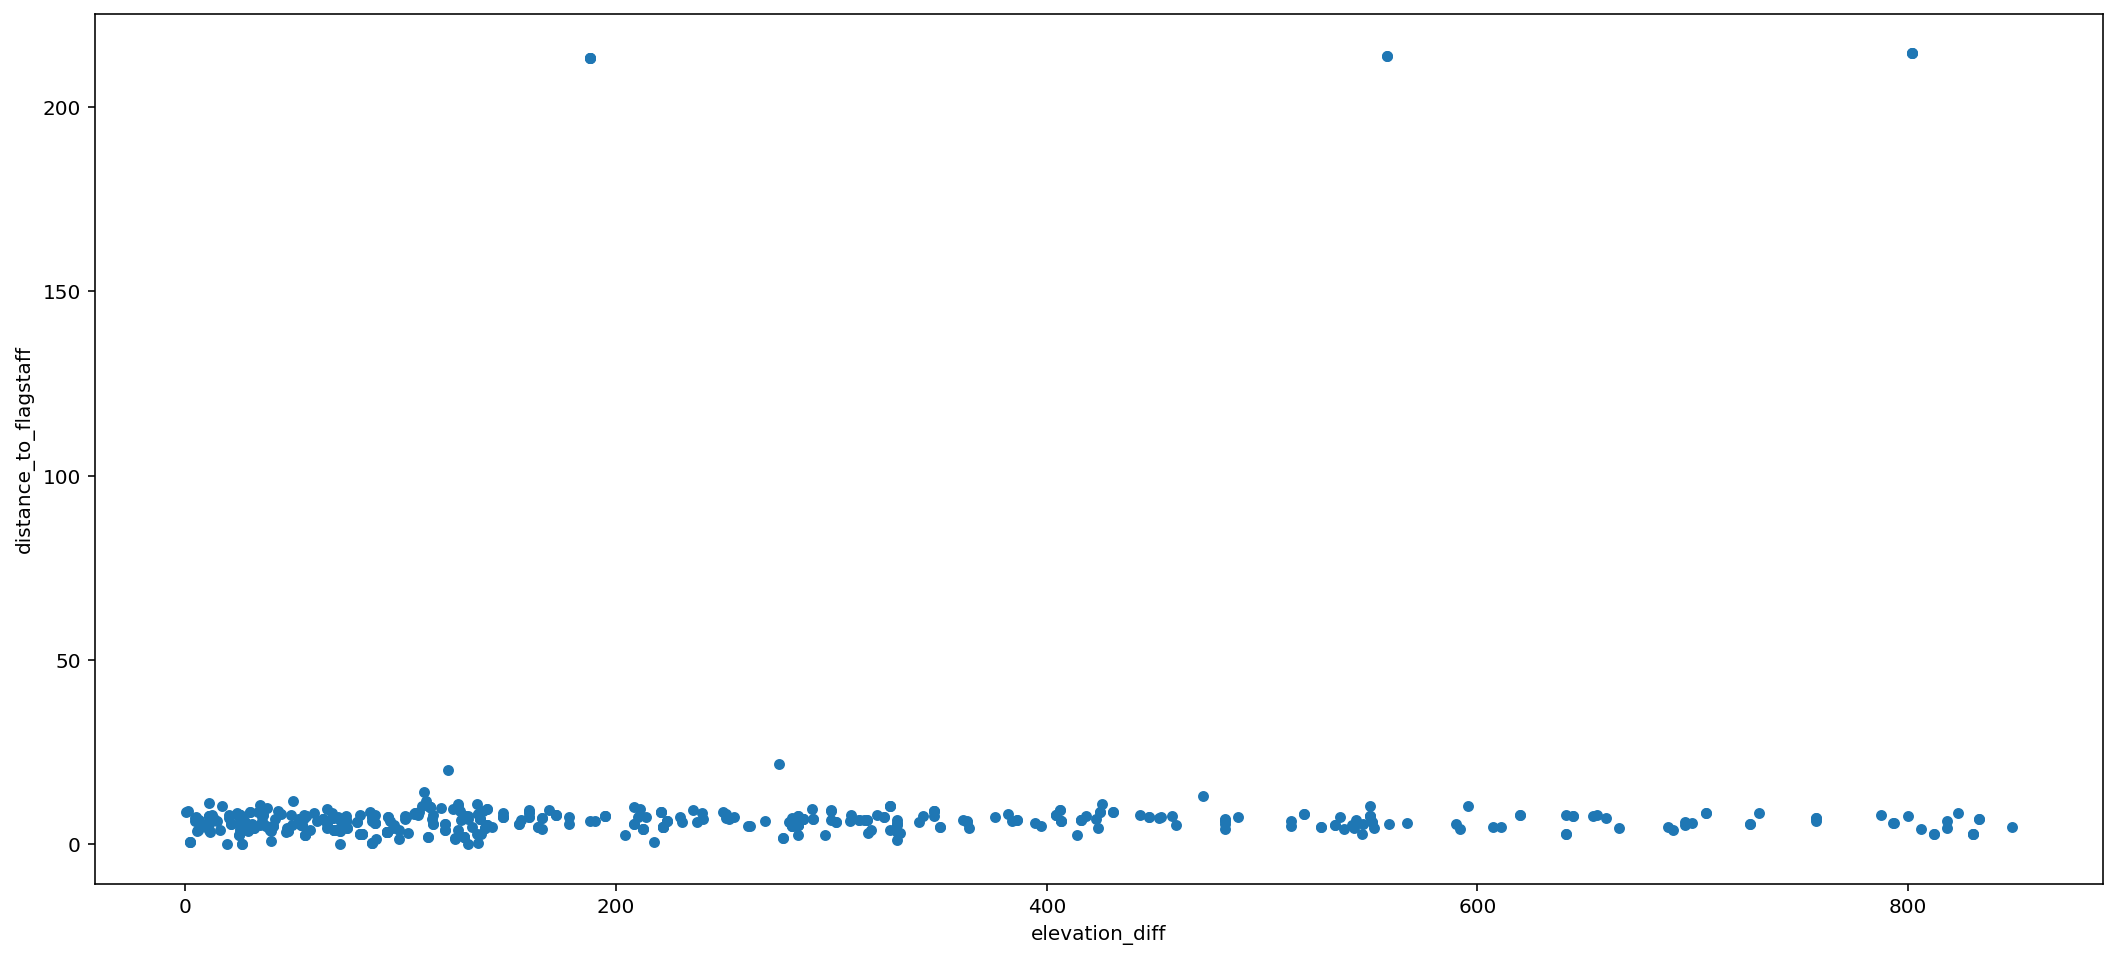

In [25]:

# Display a sample distribution of Flagstaff-like weather stations
from matplotlib_inline.backend_inline import set_matplotlib_formats

set_matplotlib_formats('retina')
fig = plt.figure(figsize=(18, 8))
ax = fig.add_subplot(1, 1, 1)
AxesSubplot_obj = climates_df[climates_df.is_like_flagstaff].sample(500).plot(x='elevation_diff', y='distance_to_flagstaff', ax=ax, kind='scatter')

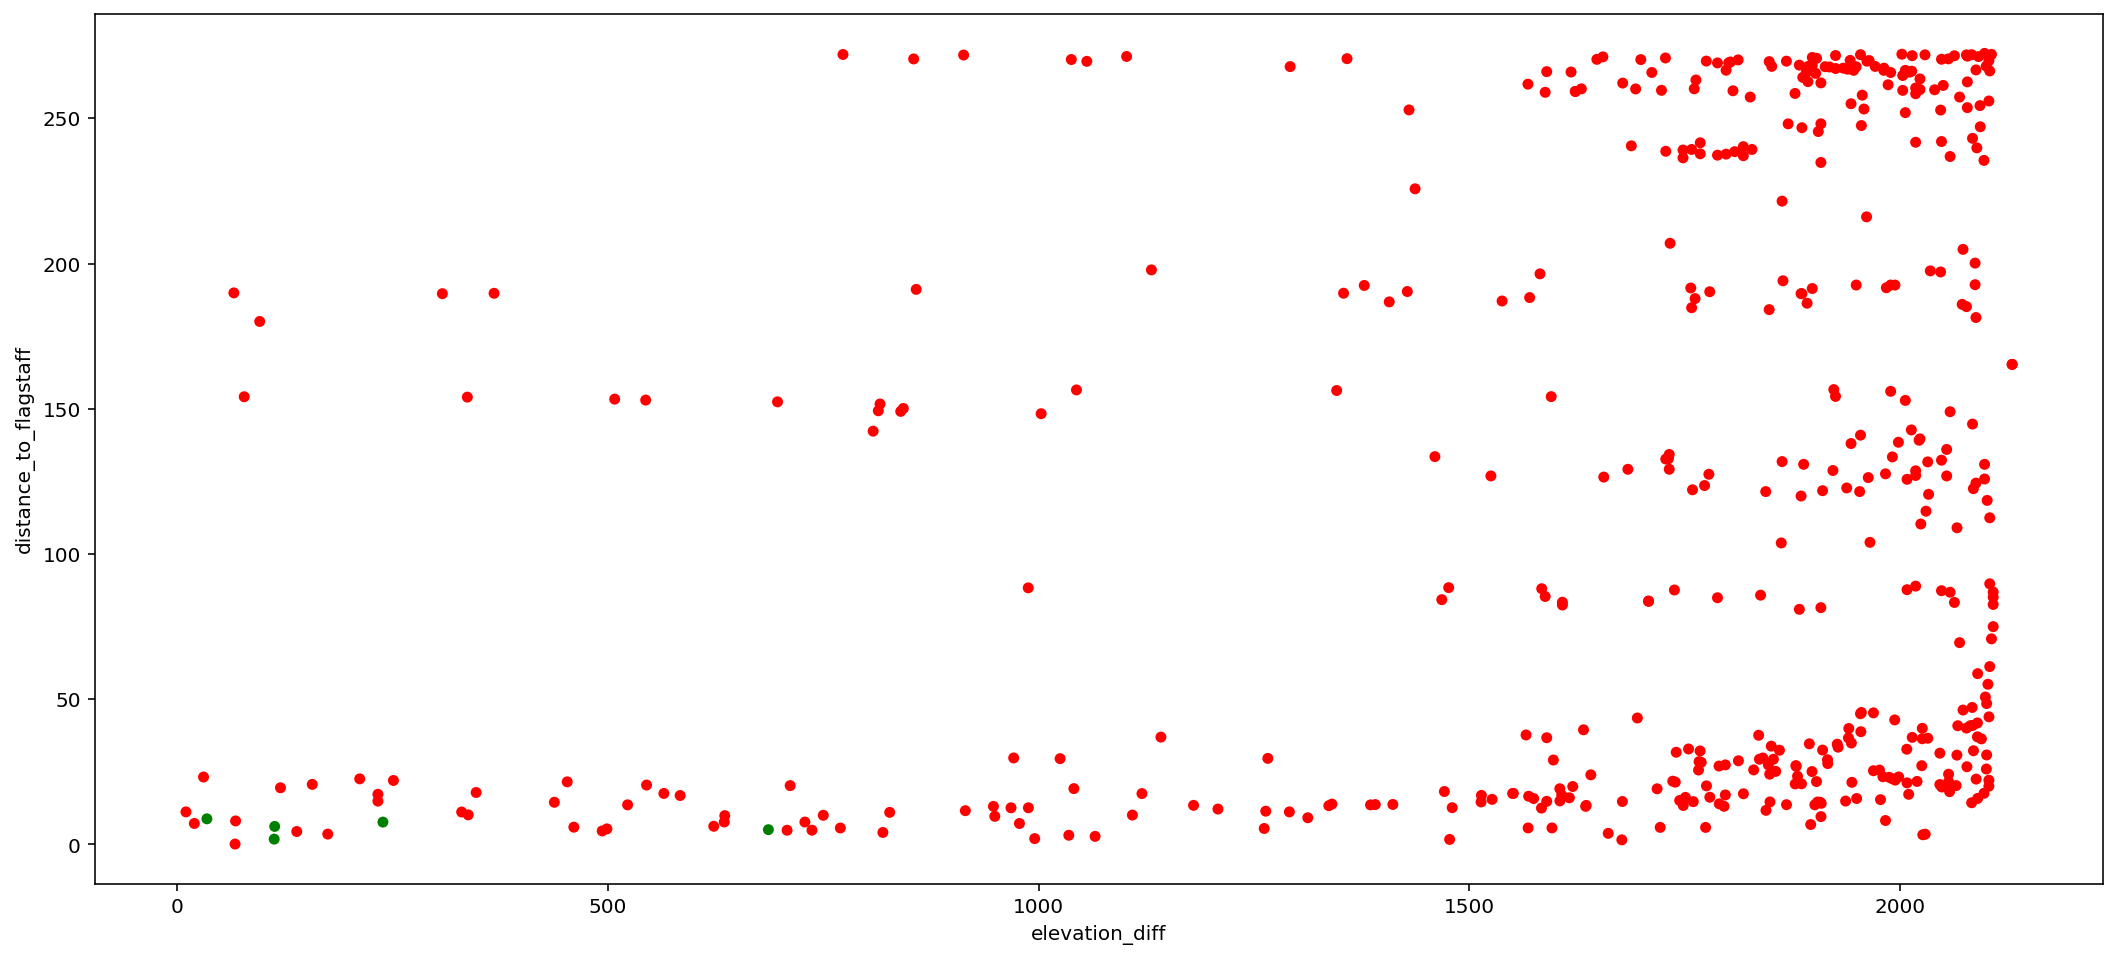

In [26]:

# Display a sample of the total distribution
df = climates_df.sample(500)
idx_list = df[df.is_like_flagstaff].index
colors_list = ['green' if x else 'red' for x in df.index.map(lambda x: x in idx_list)]
fig = plt.figure(figsize=(18, 8))
ax = fig.add_subplot(111, autoscale_on=True)
path_collection = df.plot(x='elevation_diff', y='distance_to_flagstaff', ax=ax, kind='scatter', c=colors_list)

In [27]:

climates_df.groupby('elevation_diff').distance_to_flagstaff.max().head(20)

elevation_diff
0.0    21.102102
0.3     8.802506
0.6     5.127756
0.9    19.623067
1.2    18.633362
1.8    16.746147
2.1    16.077287
2.4     7.942295
2.7    21.477546
3.0     3.615930
3.1    17.493024
3.3     5.773408
4.0    19.979073
4.3    46.848962
4.9    26.542465
5.2    16.426187
5.5     6.974672
5.8    18.139283
6.1    10.334515
6.4     6.713603
Name: distance_to_flagstaff, dtype: float64

In [28]:

climates_df.groupby('distance_to_flagstaff').elevation_diff.max().head(20)

distance_to_flagstaff
0.015466      2.1
0.033182     13.7
0.038253     11.0
0.041132     38.7
0.048086      7.0
0.051328      NaN
0.054129     16.5
0.056222     26.5
0.058317     25.6
0.073646      7.0
0.088039     63.7
0.106132    123.1
0.113344     29.3
0.114066    132.3
0.115094    131.4
0.130167     66.1
0.136357     34.1
0.141722    857.7
0.144000     67.4
0.147351     19.5
Name: elevation_diff, dtype: float64

In [29]:

# Get the Wikipedia articles near Flagstaff, AZ, USA
# Latitude and longitude coordinates are: 35.198284, -111.651299
import wikipedia

# print([f'wikipedia.{fn}' for fn in dir(wikipedia) if not fn.startswith('_')])
flagstaff_latitude = 35.198284
flagstaff_longitude = -111.651299
wikipedia.geosearch(latitude=flagstaff_latitude, longitude=flagstaff_longitude)

['Orpheum Theater (Flagstaff, Arizona)', 'Flagstaff station', 'Weatherford Hotel', 'First Baptist Church (Flagstaff, Arizona)', 'Our Lady of Guadaloupe Church', 'Hotel Monte Vista', 'Downtown Flagstaff, Arizona', 'Presbyterian Church Parsonage (Flagstaff, Arizona)', 'Brannen-Devine House', 'Flagstaff High School']


# Make a Bounding Box around Australia

In [31]:

# From https://en.wikipedia.org/wiki/List_of_extreme_points_of_Australia
from dms2dec.dms_convert import dms2dec

northernmost_latitude = dms2dec('''9°8'23" S''')
southernmost_latitude = dms2dec('''55°03' S''')
easternmost_longitude = dms2dec('''167°57' E''')
westernmost_longitude = dms2dec('''72°34' E''')
mask_series = climates_df.is_like_flagstaff
mask_series = mask_series & (climates_df.LATITUDE <= northernmost_latitude) & (climates_df.LATITUDE >= southernmost_latitude)
mask_series = mask_series & (climates_df.LONGITUDE >= westernmost_longitude) & (climates_df.LONGITUDE <= easternmost_longitude)
columns_list = ['STATION', 'NAME', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'distance_to_flagstaff', 'wikipedia_url']
df = climates_df[mask_series][columns_list]
df = df.sort_values('distance_to_flagstaff', ascending=False)
df.loc[df.NAME.shift(-1) != df.NAME].head(20)

,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,distance_to_flagstaff,wikipedia_url



# Make a Bounding Box around Arizona

In [7]:

# From https://en.wikipedia.org/wiki/List_of_extreme_points_of_U.S._states_and_territories
from dms2dec.dms_convert import dms2dec

northernmost_latitude = dms2dec('''37° N''')
southernmost_latitude = dms2dec('''31°20' N''')
easternmost_longitude = dms2dec('''109°03' W''')
westernmost_longitude = dms2dec('''114°49' W''')
mask_series = climates_df.is_like_flagstaff
mask_series = mask_series & (climates_df.LATITUDE <= northernmost_latitude) & (climates_df.LATITUDE >= southernmost_latitude)
mask_series = mask_series & (climates_df.LONGITUDE >= westernmost_longitude) & (climates_df.LONGITUDE <= easternmost_longitude)
columns_list = ['STATION', 'NAME', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'distance_to_flagstaff', 'wikipedia_url']
df = climates_df[mask_series][columns_list]
df = df.sort_values('distance_to_flagstaff', ascending=False)
df.loc[df.NAME.shift(-1) != df.NAME].head(20)

,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,distance_to_flagstaff,wikipedia_url
1699579,USC00023635,"GRANVILLE, AZ US",33.20000,-109.38333,2073.9,3.022718,NaN
1702966,USC00026202,"PALISADE RANGER STATION, AZ US",32.41667,-110.71667,2425.0,2.934435,NaN
1702238,USC00025733,"MOUNT LEMMON, AZ US",32.41667,-110.71667,2345.1,2.934435,NaN
2413412,USS0009S07S,"CORONADO TRAIL, AZ US",33.80000,-109.15000,2560.3,2.865605,https://en.wikipedia.org/wiki/Algiers_station
2413366,USS0009S06S,"BEAVER HEAD, AZ US",33.69000,-109.22000,2435.4,2.861142,NaN
1694174,USC00020159,"ALPINE, AZ US",33.84920,-109.14690,2453.6,2.844651,NaN
2413256,USS0009N05S,"BEAVER SPRING, AZ US",36.33000,-109.06000,2804.2,2.827651,https://en.wikipedia.org/wiki/Algiers_station
2413342,USS0009S04S,"NUTRIOSO, AZ US",33.90000,-109.16000,2590.8,2.809290,NaN
2413451,USS0009S11S,"HANNAGAN MEADOWS, AZ US",33.65000,-109.31000,2749.3,2.806931,NaN
1701415,USC00025129,"LUKACHUKAI, AZ US",36.41910,-109.22690,1987.3,2.714425,NaN


In [10]:

# import webbrowser
import wikipedia

# invalid_path_regex = re.compile(r'[\s\{\[\}\]\\\'\%\(\)\=\/\:\"\*\?\<\>\|\x00-\x1F]+')
# file_name = invalid_path_regex.sub('_', file_name)
titles_set = set()
for row_index, row_series in df.loc[df.NAME.shift(-1) != df.NAME].iterrows():
    latitude = row_series.LATITUDE
    longitude = row_series.LONGITUDE
    station_name = row_series.NAME
    titles_list = wikipedia.geosearch(latitude=latitude, longitude=longitude, radius=1_000)
    for title_str in titles_list:
        titles_set.add(title_str)
for title_str in sorted(titles_set):
    wikipedia_url = wikipedia.page(title=title_str).url
    print(title_str, wikipedia_url)
# climates_df.loc[row_index, 'wikipedia_url'] = wikipedia_url
# webbrowser.open(wikipedia_url, new=2)

Alpine Elementary School District https://en.wikipedia.org/wiki/Alpine_Elementary_School_District
Alpine, Arizona https://en.wikipedia.org/wiki/Alpine,_Arizona
Black Mesa National Forest https://en.wikipedia.org/wiki/Black_Mesa_National_Forest
Bright Angel Lodge https://en.wikipedia.org/wiki/Bright_Angel_Lodge
Bright Angel Trail https://en.wikipedia.org/wiki/Bright_Angel_Trail
Buckey O'Neill Cabin https://en.wikipedia.org/wiki/Buckey_O%27Neill_Cabin
Butler Canyon https://en.wikipedia.org/wiki/Butler_Canyon
Butterfly Lodge https://en.wikipedia.org/wiki/Butterfly_Lodge
Cliffs Ranger Station https://en.wikipedia.org/wiki/Cliffs_Ranger_Station
El Tovar Hotel https://en.wikipedia.org/wiki/El_Tovar_Hotel
El Tovar Stables https://en.wikipedia.org/wiki/El_Tovar_Stables
Grand Canyon Depot https://en.wikipedia.org/wiki/Grand_Canyon_Depot
Grand Canyon High School https://en.wikipedia.org/wiki/Grand_Canyon_High_School
Grand Canyon Inn and Campground https://en.wikipedia.org/wiki/Grand_Canyon_Inn_a

In [32]:

# Use the Random Forest predictions (takes about 12 hours)
if 'is_like_flagstaff' not in climates_df.columns:
    tqdm.pandas()
    numeric_columns_list = s.load_object('numeric_columns_list')
    rfclf = s.load_object('rfclf')
    def f(row_series):

        # Reshape your data using array.reshape(1, -1) if your data contains a single sample
        X = row_series[numeric_columns_list].fillna(0).values.reshape(1, -1)

        return rfclf.predict(X)[0]
    climates_df['is_like_flagstaff'] = climates_df.progress_apply(f, axis='columns')


# Fine tune some Clustering Algorithms

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Prog

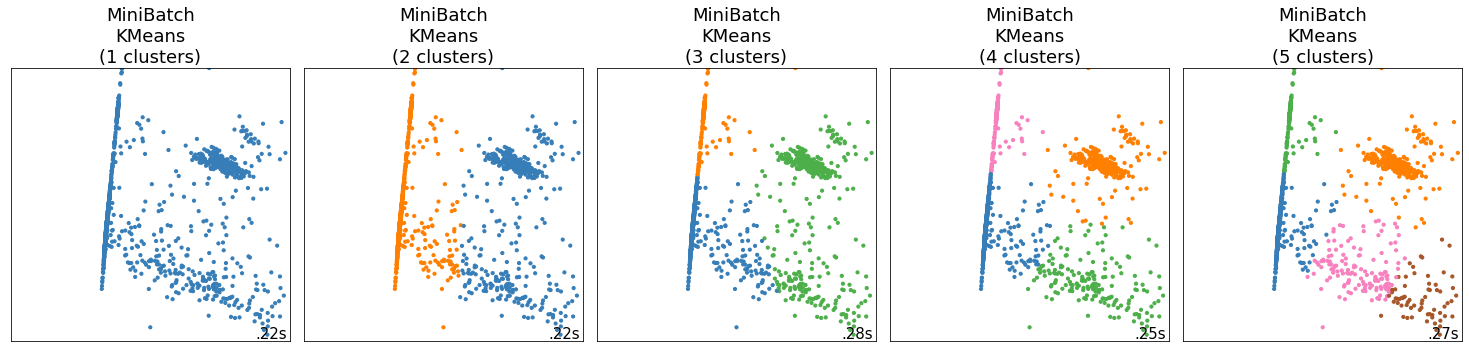

In [68]:

clustering_algorithms = [(f'MiniBatch\nKMeans\n({n_clusters} clusters)',
                          cluster.MiniBatchKMeans(n_clusters=n_clusters)) for n_clusters in range(1, 6)]
show_scatter_row(clustering_algorithms, get_ypred)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_affinity_propagation.py:250: ConvergenceWarning: Affinity propagation did not converge, this model will not have any cluster centers.
  warnings.warn(


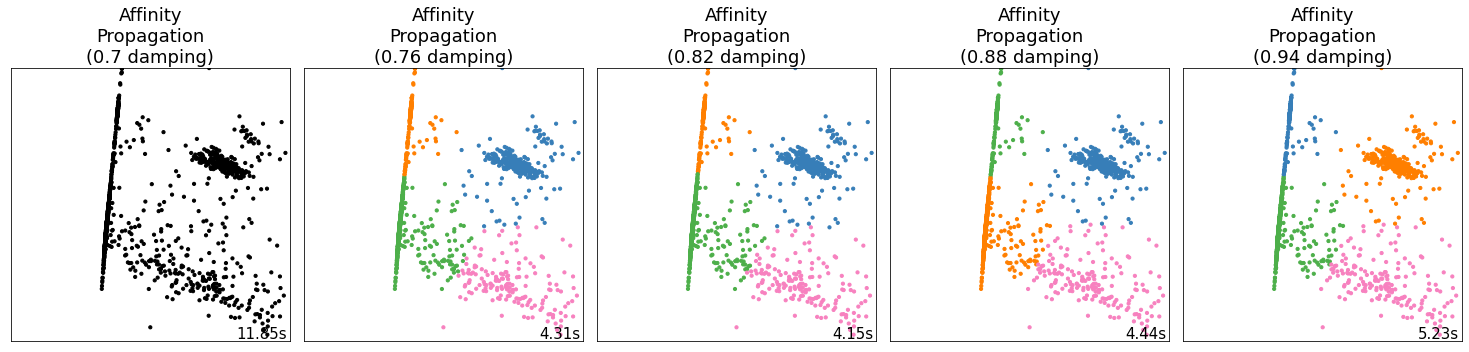

In [69]:

# Damping factor in the range [0.5, 1.0)
clustering_algorithms = [(f'Affinity\nPropagation\n({damping} damping)',
                          cluster.AffinityPropagation(preference=params['preference'],
                                                      damping=damping)) for damping in np.linspace(0.7, 1.0, num=5, endpoint=False)]
show_scatter_row(clustering_algorithms, get_ypred)

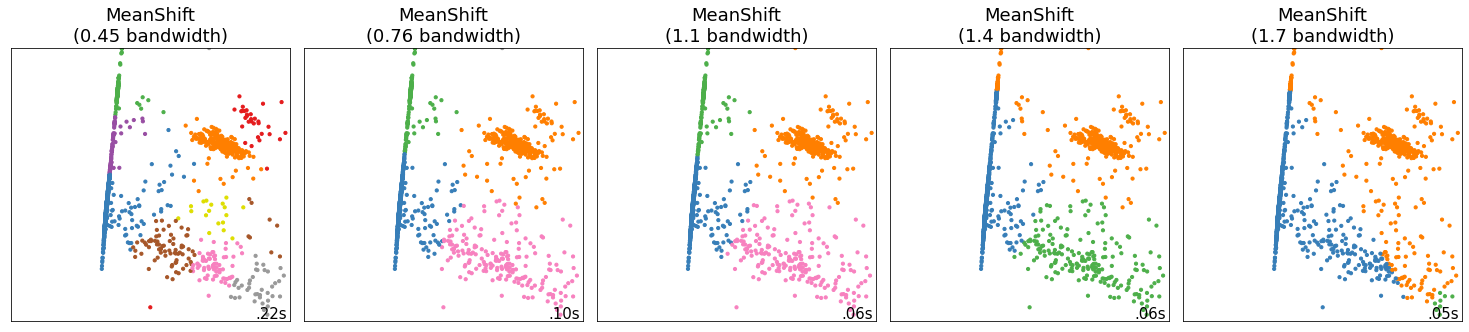

In [70]:

clustering_algorithms = [(f'MeanShift\n({bandwidth:0.2} bandwidth)',
                          cluster.MeanShift(bandwidth=bandwidth,
                                            bin_seeding=True)) for bandwidth in np.linspace(0.45, 2.0, num=5, endpoint=False)]
show_scatter_row(clustering_algorithms, get_ypred)

In [99]:

climates_df['is_near_flagstaff'] = climates_df.index.isin(nearby_list)
s.store_objects(climates_df=climates_df)

Pickling to C:\Users\daveb\OneDrive\Documents\GitHub\notebooks\saves\pkl\climates_df.pkl
